<a href="https://colab.research.google.com/github/ismaelpereziimas/Procesamiento-de-Imagenes-Medicas/blob/main/Notebooks/2026_Procesamiento_de_Imagenes_Medicas_Transformaciones_Geom%C3%A9tricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Procesamiento de imágenes médicas**
----------

#Registro de imágenes médicas usando transformaciones geométricas
-------

Por: Ing. Ismael Pérez Ruiz

iperez@modelo.edu.mx


La imagens usadas fueron tomadas de:  Alam, F., & Rahman, S. U. (2019). Challenges and solutions in multimodal medical image subregion detection and registration. Journal of Medical Imaging and Radiation Sciences, 50(1), 24–30. https://doi.org/10.1016/j.jmir.2018.06.001

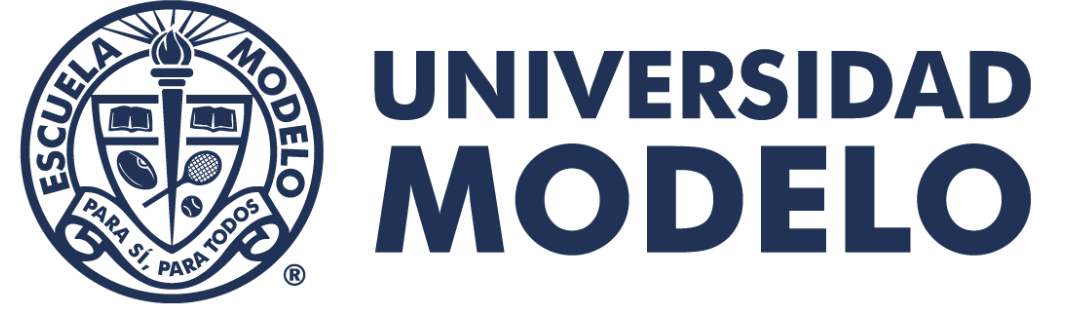

**Objetivo** Aplicar transformaciones geométricas para la fusión de dos modalidades de imágenes cerebrales.

Link del archivo de imágen: https://drive.google.com/drive/folders/1bjTvIjdQs4XS1N7p-_jG3V9Nb7WDf9CE?usp=drive_link

# Teoría previa

El registro de imágenes sirve cuando queremos combinar dos imágenes provenientes de dos modalidades diferentes. El registro de imágenes es el proceso de alinear dos o más imágenes médicas del mismo órgano que han sido adquiridas en diferentes marcos de tiempo, desde distintos ángulos o utilizando diversas modalidades. Su objetivo fundamental es integrar la información útil de estas fuentes en una sola imagen "ideal" y más informativa, permitiendo obtener datos precisos y complementarios que faciliten el diagnóstico clínico.


# Importar y visualizar imágenes

In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [84]:
imga=cv2.imread('imga.png')
imgb=cv2.imread('imgb.png')


In [85]:
imgb=cv2.cvtColor(imgb,cv2.COLOR_BGR2RGB)
imga=cv2.cvtColor(imga,cv2.COLOR_BGR2RGB)

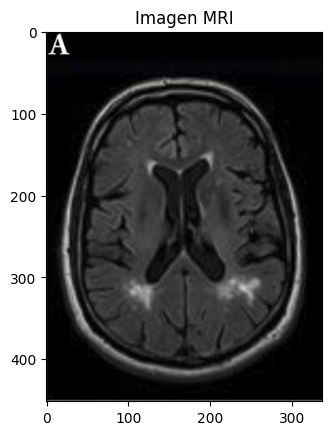

In [86]:
plt.imshow(imga)
plt.title("Imagen MRI")
plt.show()

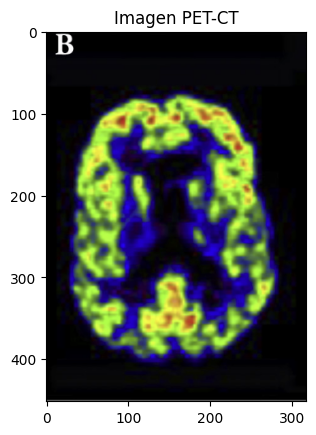

In [87]:
plt.imshow(imgb)
plt.title("Imagen PET-CT")
plt.show()

# Intentar aplicar la fusión directamente

Veamos que pasa cuando se intenta aplicar fusión de imágenes sin realizar antes un registro ni analizar sus propiedades geométricas.

In [88]:
"""
La función addWeighted realiza la suma ponderada de dos matrices, en este caso, imágenes.
A cada imagen se le da un valor de importancia, que será su contribución a la imagen final
Se propone una fusión equilibrada, en donde cada imagen tiene el mismo valor de importancia.

Para más información del método, consultar: https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19
"""
fusion=cv2.addWeighted(imga,0.5,imgb,0.5,0)


error: OpenCV(4.13.0) /io/opencv/modules/core/src/arithm.cpp:662: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


¿Por qué falló? Seguramente, esto se debe a una característica de la imagen como la resolución, veamos cuál es la resolución espacial de cada imagen.

In [89]:
imga.shape

(452, 338, 3)

In [90]:
imgb.shape

(452, 318, 3)

Como se puede observar, las resoluciones son diferentes en cada caso, por lo que se aplicará una técnica denominada *"padding"* en la cual rellenaremos la menor para que tenga las mismas dimensiones.

# Aplicación del padding

Como la imagen más pequeña es la imagen de PET-CT, esa es a la que se le aplicará el padding. Este consistirá en agregar las columnas faltantes como ceros en la imagen. Si quieres conocer un poco más de esta técnica, ingresa a este link: https://medium.com/@minhazc.engg/padding-and-strides-in-cnn-58dc56493887


In [91]:
filas=452
col=20 #estas son las columnas faltantes
canales=3

ceros=np.zeros((filas,col,canales), dtype=np.uint8)

In [92]:
imgb=np.hstack((imgb,ceros))

In [93]:
imga.shape

(452, 338, 3)

In [94]:
imgb.shape

(452, 338, 3)

In [95]:
fusion=cv2.addWeighted(imga,0.5,imgb,0.5,0)

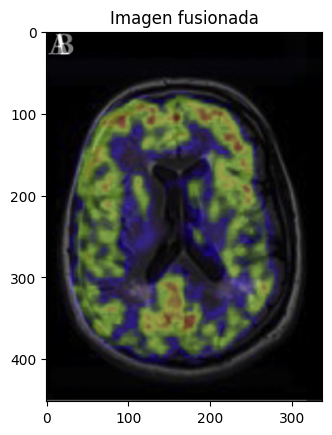

In [96]:
plt.imshow(fusion)
plt.title("Imagen fusionada")
plt.show()

¿Es la fusión más óptima? La realidad es que no. Como se puede observar, las imagenes no calzan correctamente, por lo que es necesario aplicar transformaciones geométricas para mejorar el match entre ellas.

# Transformaciones geométricas

Intentaremos primero con transformaciones de traslación y rotación.

In [186]:
tx=12
ty=100
theta=np.radians(10)

In [187]:
T=np.array([
    [np.cos(theta),-np.sin(theta),tx],
    [np.sin(theta),np.cos(theta),ty],
    [0,0,1]
])

In [188]:
filas,columnas,capas=imga.shape

In [189]:
img_reg=np.zeros((filas,columnas,capas),dtype=np.uint8)

In [190]:
T_inv=np.linalg.inv(T)

In [191]:
for x in range(filas):
  for y in range(columnas):
    destino=np.array([x,y,1])
    origen=T_inv @ destino

    x_orig=int(round(origen[0]))
    y_orig=int(round(origen[1]))

    if 0<=x_orig<filas and 0<=y_orig<columnas:
      img_reg[x,y,:]=imgb[x_orig,y_orig,:]

In [192]:
fusion= cv2.addWeighted(imga, 0.5, img_reg, 0.5, 0)

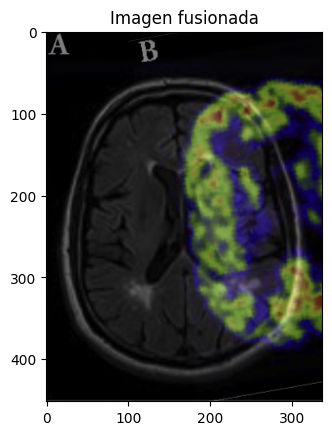

In [193]:
plt.imshow(fusion)
plt.title("Imagen fusionada")
plt.show()

# Algoritmo de pruebas

Para poder medir qué tan efectiva ha sido la técnica de transformación para el registro de la imagen, aplicaremos dos métricas:



1.   Coeficiente de correlación de Pearson: una medida estadística que cuantifica la fuerza y la dirección de la relación lineal entre dos variables continuas
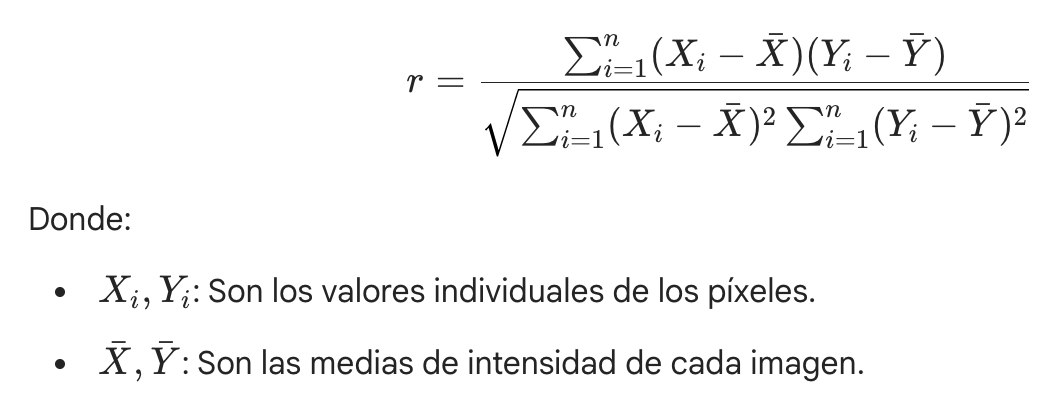


2.   Índice de información mutua: La Información Mutua es una medida estadística que cuantifica cuánta información "comparte" una imagen con otra. A diferencia de otras métricas, no busca que los píxeles sean iguales, sino que busca dependencia estadística; es decir, intenta responder a la pregunta: "Si conozco el patrón de intensidades en la imagen A, ¿qué tanto puedo predecir sobre la imagen B?"

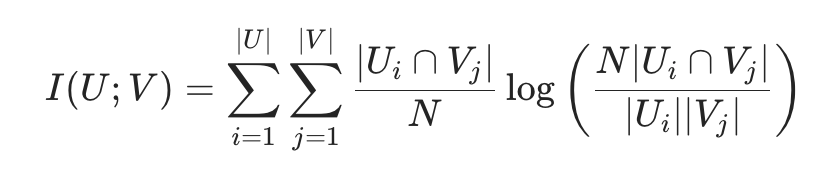





In [203]:
imga_gray=cv2.cvtColor(imga,cv2.COLOR_RGB2GRAY)
imgb_gray=cv2.cvtColor(img_reg,cv2.COLOR_RGB2GRAY)

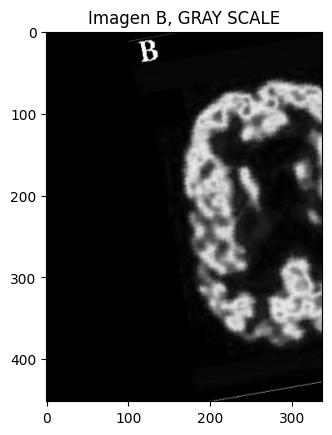

In [206]:
plt.imshow(imgb_gray, cmap="gray")
plt.title("Imagen B, GRAY SCALE")
plt.show()

In [196]:
imga_flatten=imga_gray.flatten().astype(float)
imgb_flatten=imgb_gray.flatten().astype(float)

In [200]:
print("El indice de correlacion de Pearson es: ", np.corrcoef(imga_flatten,imgb_flatten)[0,1])

El indice de correlacion de Pearson es:  0.07040987413433308


In [198]:
from sklearn.metrics import mutual_info_score

In [201]:
print("El índice de información mutua es: ", mutual_info_score(imga_flatten,imgb_flatten))

El índice de información mutua es:  0.1655767519509987
